In [26]:
import requests
import time
import re
import json
import numpy as np
import spacy
import random
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.by import By
# from config import *

nlp = spacy.load('en_core_web_lg')

def getDataFromUrl(url):
	'''
	Returns tags for the video, and list of recommended videos for the specified URL of a youtube webpage
	'''
	chrome_option = Options()
	chrome_option.add_argument("--headless")
	chrome_option.add_argument("--window-size=1920x1080")
	driver = webdriver.Chrome(executable_path="../chromedriver", chrome_options=chrome_option)
	driver.get(url)
	try:
		w = WebDriverWait(driver, 10)
		w.until(EC.presence_of_all_elements_located((By.TAG_NAME,"ytd-compact-video-renderer")))
		print("---\t---\tpage loaded")
	except:
		return None, None
	src = driver.page_source
	soup = BeautifulSoup(src, 'html.parser')
	body = soup.find("body")
	
	tags = []
	print("---\t---\tExtracting Tags")
	tag1 = 'window["ytInitialPlayerResponse"] = '
	tag2 = 'if (window.ytcsi)'
	p1 = src.find(tag1)
	p2 = p1 + src[p1:].find(tag2)
	jsontext = src[p1 + len(tag1):p2]
	jsontext = jsontext.strip()
	jsontext = jsontext[:-1]
	try:
		jsondata = json.loads(jsontext)
		tags = jsondata["videoDetails"]["keywords"]
	except:
		return None, None


	print("---\t---\tExtracting Links")

	items = body.find("ytd-app")
	items = items.find("div", id="content")
	items = items.find("ytd-page-manager", id="page-manager")
	items = items.find("ytd-watch-flexy")
	items = items.find("div", id="columns")
	items = items.find("div", id="secondary")
	items = items.find("div", id="secondary-inner")
	items = items.find("div", id="related")
	items = items.find("ytd-watch-next-secondary-results-renderer")
	items = items.find("div", id="items")
	items = items.find_all("ytd-compact-video-renderer")

	links = []

	for item in items:
		temp = item.find("div", id="dismissable")
		temp = temp.find("ytd-thumbnail")
		link = temp.find("a", id="thumbnail", href=True)
		links.append('https://www.youtube.com' + link['href'])
	driver.close()
	print("---\t---\tGot Data")
	return tags, links

def getRelevance(tags_source, tags_link):
	'''
	Return percentage relevance for two lists of tags
	'''
	print("---\t---\tCalculating relevance")
	set1 = []
	set2 = []
	for tag in tags_source:
		set1 = set1 + tag.split()
	for tag in tags_link:
		set2 = set2 + tag.split()
	
	set1 = " ".join(list(set(set1)))
	set2 = " ".join(list(set(set2)))

	sentence1 = nlp(set1)
	sentence2 = nlp(set2)

	sentence1 = nlp(" ".join([token.lemma_ for token in sentence1]))
	sentence2 = nlp(" ".join([token.lemma_ for token in sentence2]))

	sentence1 = nlp(" ".join(set([token.lemma_ for token in sentence1 if not token.is_oov])))
	sentence2 = nlp(" ".join(set([token.lemma_ for token in sentence2 if not token.is_oov])))

	# print("---\tsource:",sentence1)
	# print("---\tlink:",sentence2)

	similar = []
	for word1 in sentence1:
		max_sim = 0
		for word2 in sentence2:
			max_sim = max(word1.similarity(word2),max_sim)
		similar.append(max_sim)
	
	similar_arr = np.array(similar)
	similarity = np.linalg.norm(similar_arr)/len(similar)
	print("---\t---\tsimilarity: ",similarity)
	return similarity

In [44]:

def crawl(url, depth):
	'''
	Crawl the yt web graph and return relevance index 
	upto defined depth.
	'''
	if depth == 0:
		return 1
	
	tags, links = getDataFromUrl(url)
	if tags == None and links == None:
		print("---\t---\tpage issues...skipping page")
		return -1
	relevance = []
	links = random.sample(links,1)
    relevance_index_self = 0
	# Calculate Relevance with 1 random link
	for index, link in enumerate(links):
		print("---\tSpanning link{}/{}\tat depth{}".format(index+1,len(links), depth))
		temp_tags, _ = getDataFromUrl(link)
		if temp_tags == None:
			print("---\t---\tpage issues...skipping page")
			continue
		relevance.append(getRelevance(tags, temp_tags))
    if len(relevance):
	    relevance_index_self = sum(relevance)/len(relevance)

	# Crawl only 1 random link
	relevance_child = []
	for link in random.sample(links,1):
		temp = crawl(link, depth-1)
		if temp!=-1:
			relevance_child.append(temp)

	avg_relevance_child = 0
	if len(relevance_child):
		avg_relevance_child = sum(relevance_child)/len(relevance_child)
	prob_rele_depth = (relevance_index_self + eps)*(avg_relevance_child + eps)
    if prob_rele_depth==0:
        prob_rele_depth = 0.001
	return prob_rele_depth



In [45]:
def visualize_results(results):
	y = np.array([np.array(x) for x in results])
	y_avg = np.average(y, axis=0)
	for i in range(y.shape[0]):
		plt.plot(y[i][1:], marker='o', color='b', alpha=0.2)
	plt.plot(y_avg[1:], marker='o', color='r')
	plt.show()

In [46]:
# Start URLs
urls = []
with open("../links.txt","r") as file:
	urls = file.readlines()

In [47]:
results_for_urls = []
depth_range = 4
num_links = 4 # MAx31
lim_urls = random.sample(urls,4)
for index, url in enumerate(lim_urls):
	result = []
	for depth in range(depth_range+1):
		print("FOR \turl#{}/{} \twith depth={}/{}".format(index + 1, len(lim_urls), depth, depth_range))
		result.append(crawl(url, depth))
	results_for_urls.append(result)

FOR 	url#1/4 	with depth=0/4
FOR 	url#1/4 	with depth=1/4
---	---	page loaded
---	---	Extracting Tags
---	---	Extracting Links
---	---	Got Data
---	Spanning link1/1	at depth1
---	---	page loaded
---	---	Extracting Tags
---	---	Extracting Links
---	---	Got Data
---	---	Calculating relevance
---	---	similarity:  0.11131788597906267
FOR 	url#1/4 	with depth=2/4
---	---	page loaded
---	---	Extracting Tags
---	---	Extracting Links
---	---	Got Data
---	Spanning link1/1	at depth2
---	---	page loaded
---	---	Extracting Tags
---	---	Extracting Links
---	---	Got Data
---	---	Calculating relevance
---	---	similarity:  0.15911404122571474
---	---	page loaded
---	---	Extracting Tags
---	---	Extracting Links
---	---	Got Data
---	Spanning link1/1	at depth1
---	---	page loaded
---	---	Extracting Tags
---	---	Extracting Links
---	---	Got Data
---	---	Calculating relevance
---	---	similarity:  0.07276677423053318
FOR 	url#1/4 	with depth=3/4
---	---	page loaded
---	---	Extracting Tags
---	---	page issue

ZeroDivisionError: division by zero

In [16]:
results_for_urls

[[1, 0.31798097223009786],
 [1, 0.08513017038670631],
 [1, 0.15199957564228667],
 [1, 0.09298394172373559],
 [1, 0.10278699811351713]]

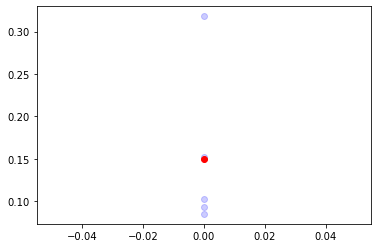

In [25]:
visualize_results(results_for_urls)